In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [3]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [4]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [5]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [6]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [7]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [8]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [11]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 2000)

In [12]:
# 첫번째 행 제거
data = data.drop(0)

In [15]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [16]:
data[:10]

,comment,label
0,그딴거 필요없고 백마나 스시녀랑 결혼하면 승자되는거 모르노?,2
1,개씹뜬금없네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,2
2,일베에서 틀딱거리는 새끼들 = 전라도 대깨문 평균나이 50대이상지들이 노인인 줄 모...,2
3,대구.경북.포항은 일베틀딱병신들만 있어서 당선됨,2
4,쓸쓸한 영화. 참 잘 만들었다.,0
5,저딴 생각을 하지?,2
6,여자 내스탈인데 뺏고싶네,1
7,La Merr~~~~,0
8,우주의 기운이나 받아라 멍충아,2
9,세계챔피언. 스트리트 파이터 되다!,0


## 중복 및 null 처리

In [17]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [18]:
detect_overlap(data)

In [19]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [20]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [21]:
x_data = data['comment']
y_data = data['label']

In [22]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [23]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [24]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 30946
단어 집합(vocabulary)에서 희귀 단어의 비율: 81.6043457623543
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 42.297336085179666


## 훈련 데이터, 테스트 데이터 분리

In [25]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

# 훈련 및 학습 데이터 분리
def config_dataset(num_train, data):
    X_test = data[num_train:] #X_data 데이터 중에서 뒤의 개의 데이터만 저장
    y_test = np.array(y_data[num_train:]) #y_data 데이터 중에서 뒤의 개의 데이터만 저장
    X_train = data[:num_train] #X_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    y_train = np.array(y_data[:num_train]) #y_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    
    return X_test, y_test, X_train, y_train

In [26]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

## 문장 길이 분포 확인

문장 최대 길이 : 194
문장 평균 길이 : 8.809512


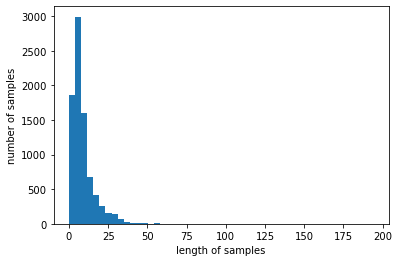

In [27]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [28]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

In [29]:
# 가장 긴 길이로 맞추기
data = pad_sequences(X_data, maxlen = maxlen)

In [30]:
X_test, y_test, X_train, y_train = config_dataset(numtrain, data)

In [31]:
X_train

array([[    0,     0,     0, ...,   993,  6979,  6980],
       [    0,     0,     0, ...,     0,  6981,   511],
       [    0,     0,     0, ...,   137,    15,  3616],
       ...,
       [    0,     0,     0, ...,   450, 32215,  3518],
       [    0,     0,     0, ...,  4526, 32217,  1970],
       [    0,     0,     0, ...,     0,   439,  1978]])

In [32]:
y_train

array([2, 2, 2, ..., 2, 1, 0], dtype=int64)

## 모델 학습

In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import tensorflow.keras.metrics 

In [67]:
size = 1000000
model = Sequential()
model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
model.add(Dropout(0.6)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
num_of_class = 3 #클래스는 우선 4개로 분류함
model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 194, 64)           64000000  
_________________________________________________________________
dropout_24 (Dropout)         (None, 194, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 192, 64)           12352     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)               

In [69]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])
es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)

## Training

In [71]:
hist = model.fit(X_train, y_train, batch_size = 16, epochs=10, callbacks=[es, check_point])

Epoch 1/10
416/416 [==============================] - 153s 369ms/step - loss: 0.9919 - accuracy: 0.5625
Epoch 2/10
416/416 [==============================] - 155s 372ms/step - loss: 0.8766 - accuracy: 0.5871
Epoch 3/10
416/416 [==============================] - 155s 372ms/step - loss: 0.6094 - accuracy: 0.7279
Epoch 4/10
416/416 [==============================] - 154s 370ms/step - loss: 0.4291 - accuracy: 0.8022
Epoch 5/10
416/416 [==============================] - 156s 375ms/step - loss: 0.3389 - accuracy: 0.8435
Epoch 6/10
416/416 [==============================] - 156s 375ms/step - loss: 0.2429 - accuracy: 0.9053
Epoch 7/10
416/416 [==============================] - 156s 375ms/step - loss: 0.1415 - accuracy: 0.9574
Epoch 8/10
416/416 [==============================] - 157s 377ms/step - loss: 0.0987 - accuracy: 0.9752
Epoch 9/10
416/416 [==============================] - 157s 378ms/step - loss: 0.0567 - accuracy: 0.9859
Epoch 10/10
416/416 [==============================] - 157s 377m

## 결과 확인

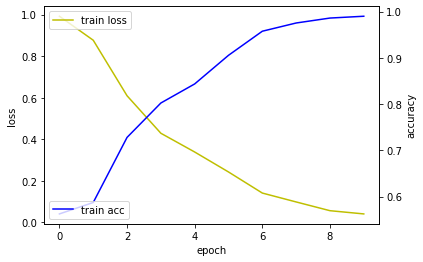

In [74]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [114]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test

result.to_csv("test_result.csv")

In [115]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

52/52 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.8507
테스트 정확도: 0.8507


## 모델 저장

In [116]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')
print("Model Saved")

Model Saved


In [117]:
##모델 조정이 아직 끝나지 않았습니다. 테스트 정확도를 더 늘리기 위해서 모델을 추가로 수정할 예정입니다,
##모델 조정이 끝나면, Model을 사용 하여 OpenMax에 필요한 자료를 선정하여 OpenMax로 구현할 예정입니다.